# Liquid and ice fraction in v1 vs v0

Super-cooled liquid fraction (SFL) based on Komurcu et al. 2014 using mixing ratios ($r$):
$$ SLF = \frac{r_{liquid}}{r_{liquid}+r_{ice}} $$

In [1]:
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob

In [44]:
figpath = '../../plots/liquid_fraction/'

color_v1 = "maroon"
color_v0 = "steelblue"

label_v1 = "SK-P"
label_v0 = "Hande"

## 1. Data

In [6]:
# find all directories which have the same name in the folder in exp_path/icon_burga_v1 and exp_path/icon_burga_v0 and store the first 8 digits of the names in a list 
#exp_path = '/data/inscape/icon/experiments/nyalesund/testbed/'
exp_path='../../data/'
exp_name_v1 = 'exp_data_v1/'
exp_name_v0 = 'exp_data_v0/'

# find all directories which have the same name in the folder in exp_path/icon_burga_v1 and exp_path/icon_burga_v0 and store the first 8 digits of the names in a list
exp_dirs_v1 = glob.glob(exp_path+exp_name_v1+'*')
exp_dirs_v0 = glob.glob(exp_path+exp_name_v0+'*')
print(exp_dirs_v1)
# sort the lists
exp_dirs_v1.sort()
exp_dirs_v0.sort()

# create a list with the first 8 digits of the names which come after the last / in the directory names
exp_names_v1 = [exp_dir.split('/')[-1][19:27] for exp_dir in exp_dirs_v1]
exp_names_v0 = [exp_dir.split('/')[-1][19:27] for exp_dir in exp_dirs_v0]
print(exp_names_v1)

# compare the lists and find the common elements
exp_dates = list(set(exp_names_v1) & set(exp_names_v0))

print(len(exp_dates))

# only select the elements which are between 20210701 and 202112031 to decrease data size and to 
#exp_dates = [exp_date for exp_date in exp_dates if int(exp_date) >= 20210801 and int(exp_date) <= 20210805]
print(len(exp_dates))
print(exp_dates)
# delete 20210905 because the Meteogram doesn't exist for this date
#exp_dates.remove('20210905')

# open all the files which are in the common elements list exp_dates
exp_dir_names_v0 = [exp_path+exp_name_v0+'/METEOGRAM_patch001_'+exp_date+'_awipev.nc' for exp_date in exp_dates]
exp_dir_names_v1 = [exp_path+exp_name_v1+'/METEOGRAM_patch001_'+exp_date+'_awipev.nc' for exp_date in exp_dates]
print(exp_dir_names_v0)

ds_v1 = xr.open_mfdataset(exp_dir_names_v1, combine='by_coords', parallel=True)
ds_v0 = xr.open_mfdataset(exp_dir_names_v0, combine='by_coords', parallel=True)

# remove the first three hours each day
ds_v1 = ds_v1.where(ds_v1.time.dt.hour >= 3, drop=True)
ds_v0 = ds_v0.where(ds_v0.time.dt.hour >= 3, drop=True)

# select only the first 100 layers of height and 99 layers of height_2 
ds_v1 = ds_v1.isel(height=slice(50,len(ds_v1.height)), height_2=slice(50,len(ds_v1.height_2)))
ds_v0 = ds_v0.isel(height=slice(50,len(ds_v0.height)), height_2=slice(50,len(ds_v0.height_2)))

['../../data/exp_data_v1/METEOGRAM_patch001_20210802_awipev.nc', '../../data/exp_data_v1/METEOGRAM_patch001_20211026_awipev.nc', '../../data/exp_data_v1/METEOGRAM_patch001_20210815_awipev.nc', '../../data/exp_data_v1/METEOGRAM_patch001_20211031_awipev.nc', '../../data/exp_data_v1/METEOGRAM_patch001_20210829_awipev.nc', '../../data/exp_data_v1/METEOGRAM_patch001_20211001_awipev.nc', '../../data/exp_data_v1/METEOGRAM_patch001_20211019_awipev.nc', '../../data/exp_data_v1/METEOGRAM_patch001_20210825_awipev.nc', '../../data/exp_data_v1/METEOGRAM_patch001_20211024_awipev.nc', '../../data/exp_data_v1/METEOGRAM_patch001_20211007_awipev.nc', '../../data/exp_data_v1/METEOGRAM_patch001_20211018_awipev.nc', '../../data/exp_data_v1/METEOGRAM_patch001_20211008_awipev.nc', '../../data/exp_data_v1/METEOGRAM_patch001_20210804_awipev.nc', '../../data/exp_data_v1/METEOGRAM_patch001_20210811_awipev.nc', '../../data/exp_data_v1/METEOGRAM_patch001_20211014_awipev.nc', '../../data/exp_data_v1/METEOGRAM_patch

### 1.1 Cloud types

Because we want to compute the liquid fraction later on, I will here restrict the cloud phases to cloud droplets and cloud ice and not include precipitating hydrometeors. 

In [18]:
# How many clouds are pure ice, pure liquid and mixed phase?

# count total amount of clouds (i.e. sum of QC + QI > 1e-8)
total_clouds_v0 = (ds_v0.QC.values + ds_v0.QI.values >= 1e-8).sum()
print(total_clouds_v0)
total_clouds_v1 = (ds_v1.QC.values + ds_v1.QI.values >= 1e-8).sum()
print(total_clouds_v1)

# count how many cases are true
li_clouds_v0 = ((ds_v0.QC.values >= 1e-8) & (ds_v0.QI.values < 1e-8)).sum()
print('liquid clouds v0:', li_clouds_v0)
li_clouds_v1 = ((ds_v1.QC.values >= 1e-8) & (ds_v1.QI.values < 1e-8)).sum()
print('liquid clouds v1:', li_clouds_v1)

ice_clouds_v0 = ((ds_v0.QC.values < 1e-8) & (ds_v0.QI.values >= 1e-8)).sum()
print('ice clouds v0:', ice_clouds_v0)
ice_clouds_v1 = ((ds_v1.QC.values < 1e-8) & (ds_v1.QI.values >= 1e-8)).sum()
print('ice clouds v1:', ice_clouds_v1)

mpc_clouds_v0 = ((ds_v0.QC.values >= 1e-8) & (ds_v0.QI.values >= 1e-8)).sum()
print('mixed phase clouds v0:', mpc_clouds_v0)
mpc_clouds_v1 = ((ds_v1.QC.values >= 1e-8) & (ds_v1.QI.values >= 1e-8)).sum()
print('mixed phase clouds v1:', mpc_clouds_v1)

# calculate the percentage
li_clouds_perc_v0 = li_clouds_v0 / total_clouds_v0 * 100
li_clouds_perc_v1 = li_clouds_v1 / total_clouds_v1 * 100
ice_clouds_perc_v0 = ice_clouds_v0 / total_clouds_v0 * 100
ice_clouds_perc_v1 = ice_clouds_v1 / total_clouds_v1 * 100
mpc_clouds_perc_v0 = mpc_clouds_v0 / total_clouds_v0 * 100
mpc_clouds_perc_v1 = mpc_clouds_v1 / total_clouds_v1 * 100

print('liquid clouds v0 in %:', li_clouds_perc_v0)
print('liquid clouds v1 in %:', li_clouds_perc_v1)
print('ice clouds v0 in %:', ice_clouds_perc_v0)
print('ice clouds v1 in %:', ice_clouds_perc_v1)
print('mixed phase clouds v0 in %:', mpc_clouds_perc_v0)
print('mixed phase clouds v1 in %:', mpc_clouds_perc_v1)



12377278
11418622
liquid clouds v0: 1964855
liquid clouds v1: 1418263
ice clouds v0: 9742915
ice clouds v1: 9278903
mixed phase clouds v0: 669488
mixed phase clouds v1: 721435
liquid clouds v0 in %: 15.874693935128548
liquid clouds v1 in %: 12.420614326317134
ice clouds v0 in %: 78.71613613267796
ice clouds v1 in %: 81.26114517145764
mixed phase clouds v0 in %: 5.409008345776834
mixed phase clouds v1 in %: 6.318056592117682


#### Subselection based on temperature

Subselection of data for temperatures below -40°C

In [4]:
# only select the cases where the temperature is above -40°C
QC_QI_sum_v0 = ds_v0.QC.values + ds_v0.QI.values
QC_QI_sum_v1 = ds_v1.QC.values + ds_v1.QI.values
precip_sum_v0 = ds_v0.QR.values + ds_v0.QS.values + ds_v0.QG.values + ds_v0.QH.values
precip_sum_v1 = ds_v1.QR.values + ds_v1.QS.values + ds_v1.QG.values + ds_v1.QH.values


NameError: name 'ds_v0' is not defined

In [40]:

ds_v0_QC = ds_v0.QC.values[(ds_v0.T.values > 233.15) & 
                           (QC_QI_sum_v0 >= 1e-8) ] # & 
                         #  (precip_sum_v0 < 1e-8) ]
ds_v1_QC = ds_v1.QC.values[(ds_v1.T.values > 233.15) & 
                           (QC_QI_sum_v1 >= 1e-8) ] # &
                        #   (precip_sum_v1 < 1e-8)]


In [41]:

ds_v0_QI = ds_v0.QI.values[(ds_v0.T.values > 233.15) &
                            (QC_QI_sum_v0 >= 1e-8)] #&
                        #    (precip_sum_v0 < 1e-8)]
ds_v1_QI = ds_v1.QI.values[(ds_v1.T.values > 233.15) &
                            (QC_QI_sum_v1 >= 1e-8) ]# &
                         #   (precip_sum_v1 < 1e-8)]


How many clouds are pure ice, pure liquid and mixed phase?
I tried excluding precipitation but then it get's all a bit out of hand...

In [42]:
# count total amount of clouds (i.e. sum of QC + QI > 1e-8)
total_clouds_v0 = ds_v0_QC.size
print(total_clouds_v0)
total_clouds_v1 = ds_v1_QC.size
print(total_clouds_v1)


9536419
9232625


In [43]:
# count how many cases are true
li_clouds_v0 = ((ds_v0_QC >= 1e-8) & (ds_v0_QI < 1e-8)).sum()
print('liquid clouds v0:', li_clouds_v0)
li_clouds_v1 = ((ds_v1_QC >= 1e-8) & (ds_v1_QI < 1e-8)).sum()
print('liquid clouds v1:', li_clouds_v1)


liquid clouds v0: 1964855
liquid clouds v1: 1418263


In [44]:
ice_clouds_v0 = ((ds_v0_QC < 1e-8) & (ds_v0_QI >= 1e-8)).sum()
print('ice clouds v0:', ice_clouds_v0)
ice_clouds_v1 = ((ds_v1_QC < 1e-8) & (ds_v1_QI >= 1e-8)).sum()
print('ice clouds v1:', ice_clouds_v1)

mpc_clouds_v0 = ((ds_v0_QC >= 1e-8) & (ds_v0_QI >= 1e-8)).sum()
print('mixed phase clouds v0:', mpc_clouds_v0)
mpc_clouds_v1 = ((ds_v1_QC >= 1e-8) & (ds_v1_QI >= 1e-8)).sum()
print('mixed phase clouds v1:', mpc_clouds_v1)

# calculate the percentage
li_clouds_perc_v0 = li_clouds_v0 / total_clouds_v0 * 100
li_clouds_perc_v1 = li_clouds_v1 / total_clouds_v1 * 100
ice_clouds_perc_v0 = ice_clouds_v0 / total_clouds_v0 * 100
ice_clouds_perc_v1 = ice_clouds_v1 / total_clouds_v1 * 100
mpc_clouds_perc_v0 = mpc_clouds_v0 / total_clouds_v0 * 100
mpc_clouds_perc_v1 = mpc_clouds_v1 / total_clouds_v1 * 100

print('liquid clouds v0 in %:', li_clouds_perc_v0)
print('liquid clouds v1 in %:', li_clouds_perc_v1)
print('ice clouds v0 in %:', ice_clouds_perc_v0)
print('ice clouds v1 in %:', ice_clouds_perc_v1)
print('mixed phase clouds v0 in %:', mpc_clouds_perc_v0)
print('mixed phase clouds v1 in %:', mpc_clouds_perc_v1)

ice clouds v0: 6902056
ice clouds v1: 7092906
mixed phase clouds v0: 669488
mixed phase clouds v1: 721435
liquid clouds v0 in %: 20.60369830646074
liquid clouds v1 in %: 15.361427546337039
ice clouds v0 in %: 72.37576285186294
ice clouds v1 in %: 76.82437010059436
mixed phase clouds v0 in %: 7.020329119347629
mixed phase clouds v1 in %: 7.8139748987963875


### 1.2 Liquid water distribution

In [7]:
# load data 
df_QN_cloudy_v1 = pd.read_csv('../../data/processed/df_QN_v1_AO_2021_cloudy.csv')
df_QN_cloudy_v0 = pd.read_csv('../../data/processed/df_QN_v0_AO_2021_cloudy.csv')
df_Q_cloudy_v1 = pd.read_csv('../../data/processed/df_Q_v1_AO_2021_cloudy.csv')
df_Q_cloudy_v0 = pd.read_csv('../../data/processed/df_Q_v0_AO_2021_cloudy.csv')

In [8]:
# compute distribution of liquid water with temperature

# bin the data by temperature from 200 to 300 K with 1 K steps

T_bins = np.arange(200, 300, 1)
print(T_bins)

# store QC and T in a pandas dataframe
#df_QC_T_v1 = pd.DataFrame({'QC': ds_v1.QC.values.flatten(), 'T': ds_v1.T.values.flatten()})
#df_QC_T_v0 = pd.DataFrame({'QC': ds_v0.QC.values.flatten(), 'T': ds_v0.T.values.flatten()})

df_QC_T_v0 = df_Q_cloudy_v0[['QC', 'T']]
df_QC_T_v1 = df_Q_cloudy_v1[['QC', 'T']]

# bin the data by temperature
df_QC_T_v1['T_bins'] = pd.cut(df_QC_T_v1['T'], bins=T_bins)
df_QC_T_v0['T_bins'] = pd.cut(df_QC_T_v0['T'], bins=T_bins)

# 1.5 minutes

[200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217
 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235
 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253
 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271
 272 273 274 275 276 277 278 279 280 281 282 283 284 285 286 287 288 289
 290 291 292 293 294 295 296 297 298 299]


/tmp/ipykernel_3230437/3506887349.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_QC_T_v1['T_bins'] = pd.cut(df_QC_T_v1['T'], bins=T_bins)
/tmp/ipykernel_3230437/3506887349.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_QC_T_v0['T_bins'] = pd.cut(df_QC_T_v0['T'], bins=T_bins)


In [32]:
# filter out only values where T is larger than 273-30 = 243 K
df_QC_T_v1 = df_QC_T_v1[(df_QC_T_v1['T'] > 250) & (df_QC_T_v1['QC'] >= 1e-8)]
df_QC_T_v0 = df_QC_T_v0[(df_QC_T_v0['T'] > 250) & (df_QC_T_v0['QC'] >= 1e-8)]

df_QC_T_v0

,QC,T,T_bins
57,9.243324e-05,264.802569,"(264, 265]"
58,3.528044e-04,264.912400,"(264, 265]"
59,2.340303e-04,265.662348,"(265, 266]"
60,1.870876e-04,266.472915,"(266, 267]"
61,1.889649e-04,267.094163,"(267, 268]"
...,...,...,...
49603863,1.246167e-07,255.725765,"(255, 256]"
49603864,1.445934e-06,256.367538,"(256, 257]"
49603964,1.164240e-06,256.369048,"(256, 257]"
49604064,5.621145e-07,256.370621,"(256, 257]"


In [33]:
binned_var_v1 = np.histogram(df_QC_T_v1['T'], bins=T_bins)[0]
binned_var_v0 = np.histogram(df_QC_T_v0['T'], bins=T_bins)[0]

binned_var_v0

# percentage of all cases
binned_var_v1 = binned_var_v1 / len(df_Q_cloudy_v1['T'])
binned_var_v0 = binned_var_v0 / len(df_Q_cloudy_v0['T'])

#binned_var_v0


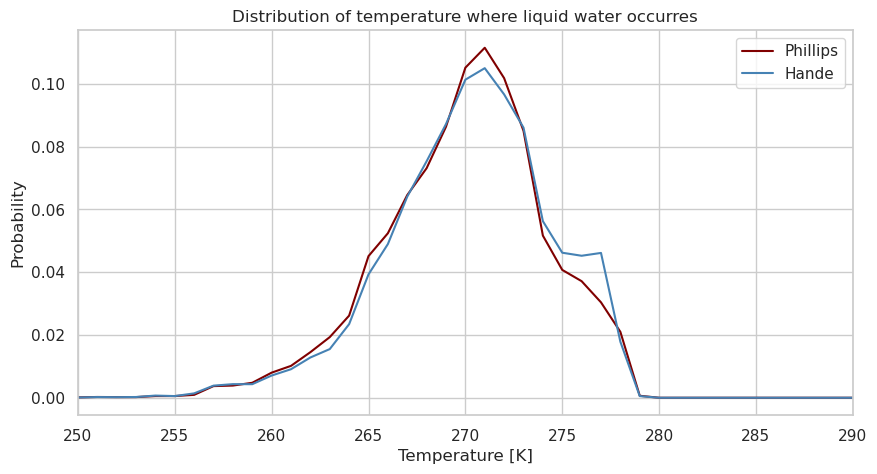

In [39]:

sns.set_theme(style="whitegrid")

# distribution of temperature where liquid water occurres
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(T_bins[:-1], binned_var_v1, label=label_v1, color=color_v1)
ax.plot(T_bins[:-1], binned_var_v0, label=label_v0, color=color_v0)

#hist_v0 = ax.hist(df_QC_T_v0['QC'], bins=T_bins, label=label_v0) #weights=df_QC_T_v0['QC'], color=color_v0, label=label_v0)
#hist_v1 = ax.hist(df_QC_T_v1['QC'], bins=T_bins, label=label_v1) #, weights=df_QC_T_v1['QC'], color=color_v1, label=label_v1)
#sns.histplot(data=df_QC_T_v1, x='T_bins', weights=df_QC_T_v1['QC'], stat='probability', color=color_v1, label=label_v1)
#sns.histplot(data=df_QC_T_v0, x='T_bins', weights=df_QC_T_v0['QC'], stat='probability', color=color_v0, label=label_v0)
ax.set_xlabel('Temperature [K]')
ax.set_ylabel('Probability')
ax.set_title('Distribution of temperature where liquid water occurres')
ax.set_xlim(250, 290)
ax.legend()


In [ ]:
ds_v0.QC.groupby(ds_v0.T) 

In [ ]:

plt.figure(figsize=(10,10))
# plot binned data. plot mean QC for each bin
ds_v0.QC.mean(dim='time').groupby('T_bins').mean().plot(label=label_v0, color=color_v0)
ds_v1.QC.mean(dim='time').groupby('T_bins').mean().plot(label=label_v1, color=color_v1)

plt.legend()
plt.xlabel('Temperature [K]')



### 2.2 Compute SLF

To do this only mixed-phase clouds are chosen.

In [19]:
# using pandas dataframe
QC_v0 = df_Q_cloudy_v0['QC'][(df_Q_cloudy_v0['QC'] >= 1e-8) & (df_Q_cloudy_v0['QI']>= 1e-8)]
QI_v0 = df_Q_cloudy_v0['QI'][(df_Q_cloudy_v0['QC'] >= 1e-8) & (df_Q_cloudy_v0['QI']>= 1e-8)]

QC_v1 = df_Q_cloudy_v1['QC'][(df_Q_cloudy_v1['QC'] >= 1e-8) & (df_Q_cloudy_v1['QI']>= 1e-8)]
QI_v1 = df_Q_cloudy_v1['QI'][(df_Q_cloudy_v1['QC'] >= 1e-8) & (df_Q_cloudy_v1['QI']>= 1e-8)]

T_v1 = df_Q_cloudy_v1['T'][(df_Q_cloudy_v1['QC'] >= 1e-8) & (df_Q_cloudy_v1['QI']>= 1e-8)]
T_v0 = df_Q_cloudy_v0['T'][(df_Q_cloudy_v0['QC'] >= 1e-8) & (df_Q_cloudy_v0['QI']>= 1e-8)]

SLF_v0 = QC_v0/(QC_v0+QI_v0)
SLF_v1 = QC_v1/(QC_v1+QI_v1)

In [45]:
# using xarray dataset
QC_v0 = ds_v0['QC'].values[(ds_v0.QC.values >= 1e-8) & (ds_v0.QI.values >= 1e-8)]
QI_v0 = ds_v0['QI'].values[(ds_v0.QC.values >= 1e-8) & (ds_v0.QI.values >= 1e-8)]

SLF_v0 = QC_v0/(QC_v0+QI_v0)
SLF_v1 = QC_v1/(QC_v1+QI_v1)

NameError: name 'QC_v1' is not defined

In [20]:
SLF_v0 = SLF_v0[~np.isnan(SLF_v0)]
SLF_v1 = SLF_v1[~np.isnan(SLF_v1)]
T_v0 = T_v0[~np.isnan(SLF_v0)]
T_v1 = T_v1[~np.isnan(SLF_v1)]

In [36]:
#SLF_v1
SLF_v0
T_v0.min()

249.30302944631023

## 2. Plots

### 2.1. stuff

Text(0.5, 0, 'SLF')

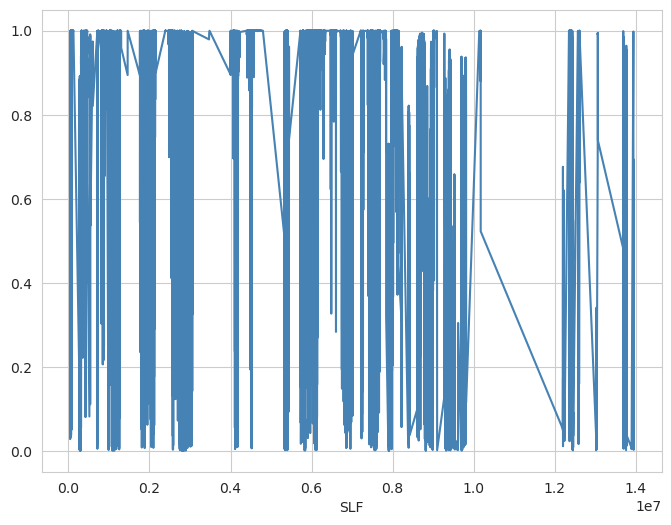

In [24]:
sns.set_style("whitegrid")

plt.figure(figsize=(8,6))
#sns.histplot(SLF_v1, bins=50, color=color_v1, label=label_v1)
plt.plot(SLF_v0, color=color_v0, label=label_v0)
plt.xlabel('SLF')
#plt.ylabel('count')

(array([  1318.,   1279.,   1142.,    986.,   1010.,    960.,    833.,
          1029.,   1078.,   1198.,   1205.,   1238.,   1278.,   1236.,
          1396.,   1501.,   1598.,   1616.,   1660.,   2010.,   1980.,
          1843.,   2009.,   2037.,   2188.,   1979.,   2423.,   2160.,
          2276.,   2844.,   3391.,   3650.,   3391.,   3083.,   3290.,
          3228.,   3745.,   4076.,   4317.,   4863.,   5759.,   6054.,
          8144.,   9557.,  12443.,  15564.,  20562.,  31196.,  57927.,
        469885.]),
 array([2.59966704e-04, 2.02543856e-02, 4.02488046e-02, 6.02432235e-02,
        8.02376425e-02, 1.00232061e-01, 1.20226480e-01, 1.40220899e-01,
        1.60215318e-01, 1.80209737e-01, 2.00204156e-01, 2.20198575e-01,
        2.40192994e-01, 2.60187413e-01, 2.80181832e-01, 3.00176251e-01,
        3.20170670e-01, 3.40165089e-01, 3.60159508e-01, 3.80153927e-01,
        4.00148345e-01, 4.20142764e-01, 4.40137183e-01, 4.60131602e-01,
        4.80126021e-01, 5.00120440e-01, 5.20114859e-

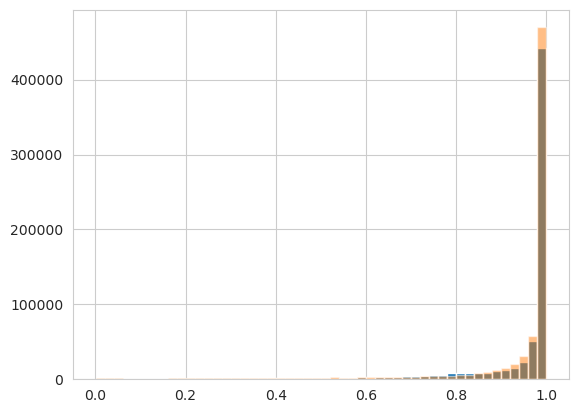

In [26]:
# count how many values in QC are larger than 1e-8
#QC_v0.where(QC_v0 >= 1e-8).count()
#QC_v1.where(QC_v1 >= 1e-8).count()
#QI_v0.where(QI_v0 >= 1e-8).count()
#QI_v1.where(QI_v1 >= 1e-8).count()

# is not nan
plt.figure()
plt.hist(SLF_v0[(SLF_v0 > 0) & (SLF_v0 < 1)], bins=50)     #.hist(bins=50)
plt.hist(SLF_v1, bins=50, alpha=0.5)    



Text(0.5, 0, 'SLF')

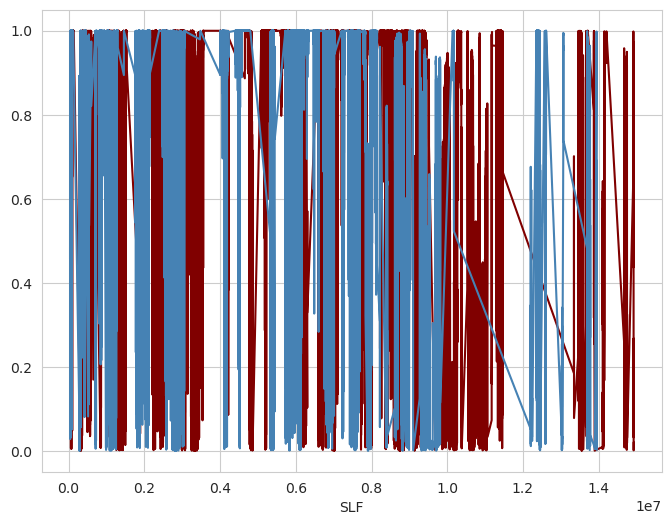

In [25]:
sns.set_style("whitegrid")

plt.figure(figsize=(8,6))
plt.plot(SLF_v1, color=color_v1, label=label_v1)
plt.plot(SLF_v0, color=color_v0, label=label_v0)
plt.xlabel('SLF')
#plt.ylabel('count')

### 2.2  plot liquid fraction with temp

In [42]:
# bin the temperature data by 1 K steps
T_bins = np.arange(250, 274, 1)
print(T_bins)

# store SLF and T in a pandas dataframe
df_SLF_T_v1 = pd.DataFrame({'SLF': SLF_v1, 'T': T_v1})
df_SLF_T_v0 = pd.DataFrame({'SLF': SLF_v0, 'T': T_v0})

# bin the data by temperature
df_SLF_T_v1['T_bins'] = pd.cut(df_SLF_T_v1['T'], bins=T_bins)
df_SLF_T_v0['T_bins'] = pd.cut(df_SLF_T_v0['T'], bins=T_bins)

# compute the average SLF for each temperature bin
binned_var_v1 = df_SLF_T_v1.groupby('T_bins')
binned_var_v0 = df_SLF_T_v0.groupby('T_bins')

# mean value
mean_var_v1 = binned_var_v1.mean()
mean_var_v0 = binned_var_v0.mean()

# count per bin
count_var_v1 = binned_var_v1.count()
count_var_v0 = binned_var_v0.count()


[250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267
 268 269 270 271 272 273]


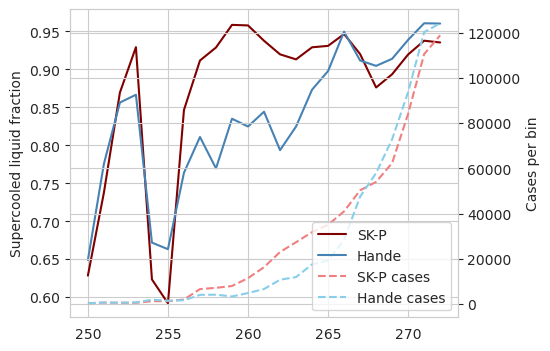

In [55]:

# plot the average liquid fraction for each temperature bin
fig, ax = plt.subplots(figsize=(5,4))
plt.plot(T_bins[:-1], mean_var_v1['SLF'].values, color=color_v1, label=label_v1)
plt.plot(T_bins[:-1], mean_var_v0['SLF'].values, color=color_v0, label=label_v0)
plt.ylabel('Supercooled liquid fraction')
# add count per bin to the plot on an additional y-axis as dashed lines
ax2 = ax.twinx()
ax2.plot(T_bins[:-1], count_var_v1['SLF'], color="lightcoral", label=label_v1+" cases", linestyle='--')
ax2.plot(T_bins[:-1], count_var_v0['SLF'], color="skyblue", label=label_v0+" cases", linestyle='--')
plt.xlabel('Temperature [K]')
plt.ylabel('Cases per bin')
# put all labels into one legend box
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc="lower right")

plt.savefig(figpath+'SLF_T_v1_v0_AO_2021.svg', dpi=300, bbox_inches='tight')


In [33]:
binned_var_v1['SLF']

T_bins
(250, 251]    0.628473
(251, 252]    0.737716
(252, 253]    0.869498
(253, 254]    0.929255
(254, 255]    0.623457
(255, 256]    0.592053
(256, 257]    0.846601
(257, 258]    0.911699
(258, 259]    0.928808
(259, 260]    0.958582
(260, 261]    0.957874
(261, 262]    0.937663
(262, 263]    0.919795
(263, 264]    0.913186
(264, 265]    0.929068
(265, 266]    0.930954
(266, 267]    0.946529
(267, 268]    0.920177
(268, 269]    0.876176
(269, 270]    0.893589
(270, 271]    0.919630
(271, 272]    0.937755
(272, 273]    0.935432
(273, 274]    0.956283
(274, 275]         NaN
(275, 276]         NaN
(276, 277]         NaN
(277, 278]         NaN
(278, 279]         NaN
(279, 280]         NaN
(280, 281]         NaN
(281, 282]         NaN
(282, 283]         NaN
(283, 284]         NaN
(284, 285]         NaN
(285, 286]         NaN
(286, 287]         NaN
(287, 288]         NaN
(288, 289]         NaN
Name: SLF, dtype: float64